## IDAO ([International Data Analysis Olympiad](https://idao.world/bootcamp/)) | 24 hours competition | Nicolás Hörmann

These are the experiments I wrote for the IDAO competition.

This notebook divides into following steps:

- imports

- functions and exp runnner

- read an preprocess the data

- reproducible pipelines definition

- run experiments using several pipelines and see all the partial results in each experimentation iteration (waves)

In [ ]:
!pip install catboost xgboost==1.4.2 lightgbm==3.2.1
!pip install scikit-learn  -U
!pip install scipy==1.5.3

## Imports

In [2]:
import warnings
import numpy as np 
import pandas as pd
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, clone
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif, SelectKBest, RFE, SelectFromModel
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
warnings.filterwarnings("ignore")

## Functions and exp runnner

In [3]:
def preprocess_data(df_train, df_test, save=False):
    """
    Preprocess data with basic transformations.
    """
    df_train_c = df_train.copy()
    df_test_c = df_test.copy()
    df_test_c['insomnia'] = np.nan
    df_train_c['is_train'] = 1
    df_test_c['is_train'] = 0
    dataset = pd.concat([df_train_c, df_test_c])
    dataset['sex'] = dataset['sex'].map({2: 1, 1: 0})
    if save:
        print(f'Saving the dataset. Full shape: {dataset.shape}')
        dataset.to_csv('dataset_nh.csv', index=False)
        print("Dataset saved.")
    else:
        return dataset.reset_index(drop=True)

    
def data_reader():
    """Data reader function."""
    path = 'dataset_nh.csv'
    dataset = pd.read_csv(path)
    return dataset


def plot_pipelines_results(df_results):
    plt.subplots(figsize=(18, 7))
    ax = sns.scatterplot(data=df_results,
                         y='pipeline',
                         x='logloss',
                         hue='dataset')
    valid_values = list(df_results.query("dataset == 'validation'").logloss)
    ax.grid()
    for v_ in valid_values:
        ax.axvline(x=v_, alpha=0.25, color='red')
    plt.show()

In [4]:
def split_dataset(dataset, split_instance):
    """
    Split the dataset using a split instance which should has a
    split method. Returns a dict with the split dataset.
    """
    return split_instance.split(dataset)

class Split(ABC):
    """Split dataset abstract class."""

    @abstractmethod
    def split(self, dataset):
        """split method.

        Should return the data splits.
        """
        pass

class SplitDefault(Split):
    """Split dataset into train, validation, full_train and test."""

    def __init__(self, split_col='is_train', target_col='insomnia'):
        self._split_col = split_col
        self._target_col = target_col

    def split(self, dataset):
        train_ix = dataset[dataset[self._split_col] == 1].index
        test_ix = dataset[dataset[self._split_col] == 0].index

        X_full_train = dataset.loc[train_ix].reset_index(drop=True)
        y_full_train = X_full_train[self._target_col]
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_full_train, y_full_train, train_size=0.7, random_state=42
        )

        X_test = dataset.loc[test_ix].reset_index(drop=True)

        return {
            'train': (X_train, y_train),
            'validation': (X_valid, y_valid),
            'full_train': (X_full_train, y_full_train),
            'test': (X_test, X_test[self._target_col])
        }

In [5]:
def run_pipeline(X_train, y_train, X_test, y_test, pipeline):
    """
    Run a specific pipeline in train and predict in test.
    """
    pipeline.fit(X_train, y_train)
    return (
        pipeline.predict_proba(X_train), pipeline.predict_proba(X_test)
    )


def run_experiment(data_split, pipeline_func, f_name, basic_cols,
                   grid_params=None):
    """
    Run an experiment and calculate the logloss for train and valid set.
    """
    X_train, y_train = (
        data_split['train'][0][basic_cols], data_split['train'][1]
    )
    X_valid, y_valid = (
        data_split['validation'][0][basic_cols], data_split['validation'][1]
    )
    pipeline = pipeline_func()
    if grid_params:
        train_ix = X_train.index.values
        train_offset = train_ix[-1] + 1
        val_ix = X_valid.index.values + train_offset

        X_f = pd.concat([X_train, X_valid])
        y_f = pd.concat([y_train, y_valid])

        clf = GridSearchCV(
            estimator=pipeline,
            param_grid=grid_params,
            cv=[(train_ix, val_ix)],
            n_jobs=-1,
            refit=False
        )
        clf.fit(X_f, y_f)
        pipeline.set_params(**clf.best_params_)
        print(f'Best parameters found are: {clf.best_params_}')

    train_probs, valid_probs = run_pipeline(
        X_train, y_train, X_valid, y_valid, pipeline
    )
    l_loss_train = log_loss(y_train, train_probs)
    l_loss_valid = log_loss(y_valid, valid_probs)
    return {'train': l_loss_train, 'validation': l_loss_valid}


def experiments_runner(pipelines_to_run, split_instance, dataset=None,
                       data_reader=None, grid_params=None, save_test_preds=False,
                       skip_train_valid=False):
    """
    Run a list of experimens using run_experiment function.
    Save test predictions in order to make submissions
    (if save_test_preds is True).
    Return a dataframe with train and validation logloss
    in order to compare them (if skip_train_valid is False).
    """
    BASIC_COLS = [
        'age', 'weight', 'height', 'sex', 'stress', 'doctor',
        'sport', 'pernicious_1', 'pernicious_2', 'ubp', 'lbp'
    ]
    KEY_COL = ['id']
    TARGET_COL = 'insomnia'

    if data_reader:
        dataset = data_reader()
    else:
        assert dataset is not None

    data_split = split_dataset(dataset.copy(), split_instance)
    train_valid_scores = {'pipeline': [], 'dataset': [], 'logloss': []}
    if not skip_train_valid:
        func_names = [pipe.__name__ for pipe in pipelines_to_run]
        for f_name, pipeline_func in zip(func_names, pipelines_to_run):
            print(f'Running {f_name}.')
            f_name_scores = run_experiment(
                data_split, pipeline_func, f_name, BASIC_COLS, grid_params
            )
            print(f'{f_name} run.')
            train_valid_scores['pipeline']+=([f_name] * 2)
            train_valid_scores['dataset'].append('train')
            train_valid_scores['logloss'].append(f_name_scores['train'])
            train_valid_scores['dataset'].append('validation')
            train_valid_scores['logloss'].append(f_name_scores['validation'])
    if save_test_preds:
        assert len(pipelines_to_run) == 1
        pipeline_func = pipelines_to_run[0]
        pipeline = pipeline_func()
        X_full_train, y_full_train = (
            data_split['full_train'][0], data_split['full_train'][1]
        )
        X_test, y_test = (
            data_split['test'][0], data_split['test'][1]
        )
        _, y_test_scores = run_pipeline(X_full_train[BASIC_COLS],
                                        y_full_train,
                                        X_test[BASIC_COLS],
                                        y_test,
                                        pipeline)
        test_estimations = X_test[KEY_COL].copy()
        test_estimations[TARGET_COL] = y_test_scores[:, 1]
        path = f'test_submission_{pipeline_func.__name__}.csv'
        test_estimations.to_csv(path, index=False)
        print(f"Test estimations saved. Path: {path}")

    return pd.DataFrame().from_dict(train_valid_scores)

## Read an preprocess the data

In [6]:
# download datasets from local files

df_train = pd.read_csv('../input/idao-2022-bootcamp-insomnia/TRAIN.csv')
df_test = pd.read_csv('../input/idao-2022-bootcamp-insomnia/TEST.csv')

In [7]:
dataset = preprocess_data(df_train, df_test)

## Reproducible pipelines definition

In [8]:
# Reproducible pipeline definition (better explicit and reproducible
# than implicit and confusing)

def pipeline_1():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('scaler_', StandardScaler()),
        ('model_', LogisticRegression())
    ])

## Run experiments using several pipelines

In [9]:
df_baseline = experiments_runner(
    pipelines_to_run=[pipeline_1],
    split_instance=SplitDefault(),
    dataset=dataset
)

Running pipeline_1.
pipeline_1 run.


#### We will make the first submission, our baseline:

In [10]:
experiments_runner(
    pipelines_to_run=[pipeline_1], 
    split_instance=SplitDefault(), 
    dataset=dataset, 
    save_test_preds=True, 
    skip_train_valid=True
)

Test estimations saved. Path: test_submission_pipeline_1.csv


,pipeline,dataset,logloss


#### Let's try other pipelines:

In [11]:
# Reproducible pipeline definition (better explicit and reproducible
# than implicit and confusing)

def pipeline_2():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('poly_featurizer_', PolynomialFeatures(degree=4)),
        ('scaler_', StandardScaler()),
        ('model_', LogisticRegression())
    ])

def pipeline_3():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('poly_featurizer_', PolynomialFeatures(degree=3)),
        ('scaler_', StandardScaler()),
        ('model_', LogisticRegression())
    ])

def pipeline_4():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('poly_featurizer_', PolynomialFeatures(degree=6)),
        ('scaler_', StandardScaler()),
        ('model_', LogisticRegression())
    ])

def pipeline_5():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('poly_featurizer_', PolynomialFeatures(degree=2)),
        ('scaler_', StandardScaler()),
        ('model_', LogisticRegression())
    ])

def pipeline_6():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('poly_featurizer_', PolynomialFeatures(degree=1)),
        ('scaler_', StandardScaler()),
        ('model_', LogisticRegression())
    ])

In [12]:
results_df_scd_wave = experiments_runner(
    pipelines_to_run=[pipeline_2, pipeline_3, pipeline_4,
                      pipeline_5, pipeline_6],
    split_instance=SplitDefault(),
    dataset=dataset
)

Running pipeline_2.
pipeline_2 run.
Running pipeline_3.
pipeline_3 run.
Running pipeline_4.
pipeline_4 run.
Running pipeline_5.
pipeline_5 run.
Running pipeline_6.
pipeline_6 run.


In [13]:
results_df_scd_wave = pd.concat([results_df_scd_wave,
                                 df_baseline]).sort_values('pipeline')

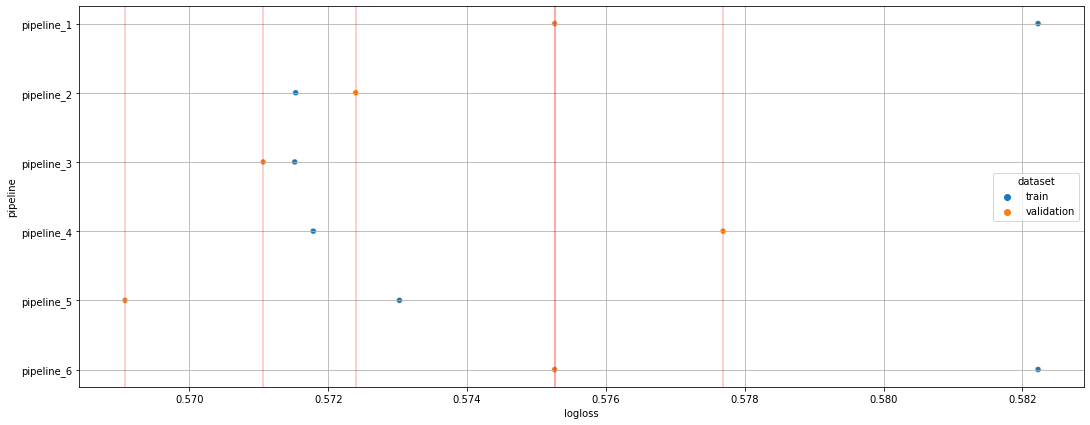

In [14]:
plot_pipelines_results(results_df_scd_wave)

Let's try feature elimination with 3 and 5

In [15]:
# Reproducible pipeline definition (better explicit and reproducible
# than implicit and confusing)

def pipeline_7():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('poly_featurizer_', PolynomialFeatures(degree=3)),
        ('scaler_', StandardScaler()),
        ('selector_', SelectKBest(score_func=mutual_info_classif, k=8)),
        ('model_', LogisticRegression())
    ])

def pipeline_8():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('poly_featurizer_', PolynomialFeatures(degree=2)),
        ('scaler_', StandardScaler()),
        ('selector_', SelectKBest(score_func=mutual_info_classif, k=4)),
        ('model_', LogisticRegression())
    ])

In [16]:
results_df_thr_wave = experiments_runner(
    pipelines_to_run=[pipeline_7, pipeline_8],
    split_instance=SplitDefault(),
    dataset=dataset
)

Running pipeline_7.
pipeline_7 run.
Running pipeline_8.
pipeline_8 run.


In [17]:
results_df_thr_wave = pd.concat([results_df_thr_wave,
                                 results_df_scd_wave]).sort_values('pipeline')

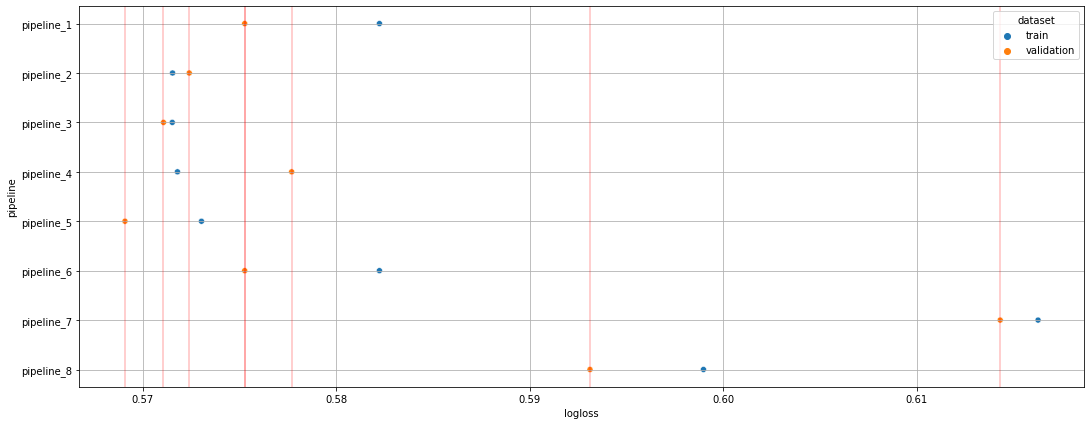

In [18]:
plot_pipelines_results(results_df_thr_wave)

Worst results.

In [19]:
def pipeline_9():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('poly_featurizer_', PolynomialFeatures(degree=3)),
        ('scaler_', StandardScaler()),
        ('selector_', RFE(LogisticRegression(max_iter=1000),
                              n_features_to_select=20,
                              step=30
                             )),
        ('model_', LogisticRegression())
    ])

In [20]:
results_df_frd_wave = experiments_runner(
    pipelines_to_run=[pipeline_9],
    split_instance=SplitDefault(),
    dataset=dataset
)

Running pipeline_9.
pipeline_9 run.


In [21]:
results_df_frd_wave = pd.concat([results_df_frd_wave,
                                 results_df_thr_wave]).sort_values('pipeline')

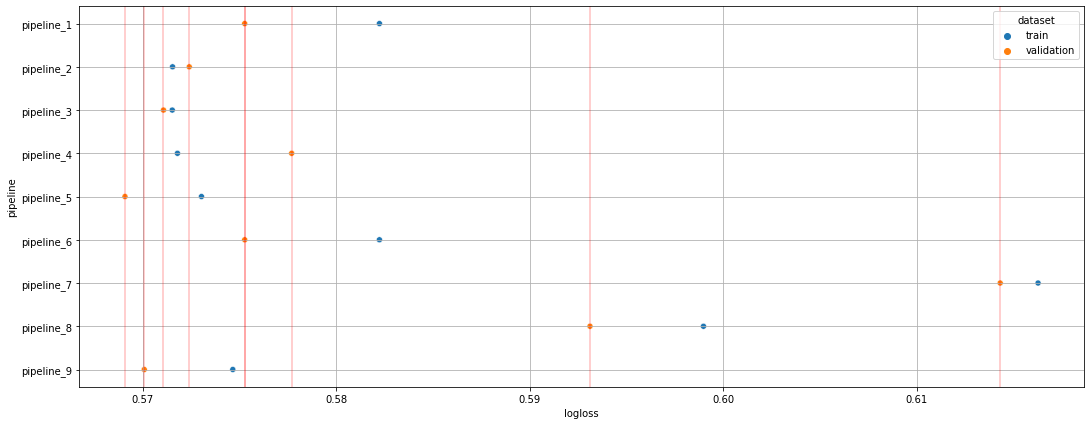

In [22]:
plot_pipelines_results(results_df_frd_wave)

In [23]:
def pipeline_10():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('poly_featurizer_', PolynomialFeatures(degree=3)),
        ('scaler_', StandardScaler()),
        ('selector_', RFE(LogisticRegression(max_iter=200),
                              n_features_to_select=10,
                              step=20
                             )),
        ('model_', LogisticRegression())
    ])

In [24]:
results_df_5_wave = experiments_runner(
    pipelines_to_run=[pipeline_10],
    split_instance=SplitDefault(),
    dataset=dataset
)

Running pipeline_10.
pipeline_10 run.


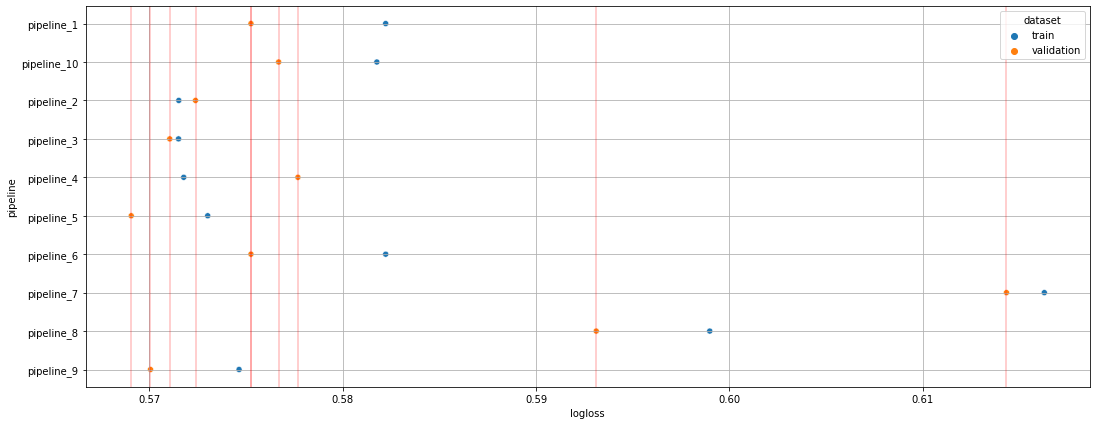

In [25]:
results_df_5_wave = pd.concat([results_df_frd_wave,
                                 results_df_5_wave]).sort_values('pipeline')
plot_pipelines_results(results_df_5_wave)

In [26]:
def pipeline_11():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('poly_featurizer_', PolynomialFeatures(degree=3)),
        ('scaler_', StandardScaler()),
        ('model_', CatBoostClassifier(silent=True,
                                      random_seed=77,
                                      loss_function='Logloss'))
    ])

def pipeline_12():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('scaler_', StandardScaler()),
        ('model_', CatBoostClassifier(silent=True,
                                      random_seed=77,
                                      loss_function='Logloss'))
    ])

def pipeline_13():
    return Pipeline([
        ('model_', CatBoostClassifier(silent=True,
                                      random_seed=77,
                                      loss_function='Logloss'))
    ])

def pipeline_14():
    return Pipeline([
        ('scaler_', StandardScaler()),
        ('model_', CatBoostClassifier(silent=True,
                                      random_seed=77,
                                      loss_function='Logloss'))
    ])

def pipeline_15():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('model_', CatBoostClassifier(silent=True,
                                      random_seed=77,
                                      loss_function='Logloss'))
    ])

In [27]:
results_df_6_wave = experiments_runner(
    pipelines_to_run=[pipeline_11, pipeline_12, pipeline_13,
                      pipeline_14, pipeline_15],
    split_instance=SplitDefault(),
    dataset=dataset
)

Running pipeline_11.
pipeline_11 run.
Running pipeline_12.
pipeline_12 run.
Running pipeline_13.
pipeline_13 run.
Running pipeline_14.
pipeline_14 run.
Running pipeline_15.
pipeline_15 run.


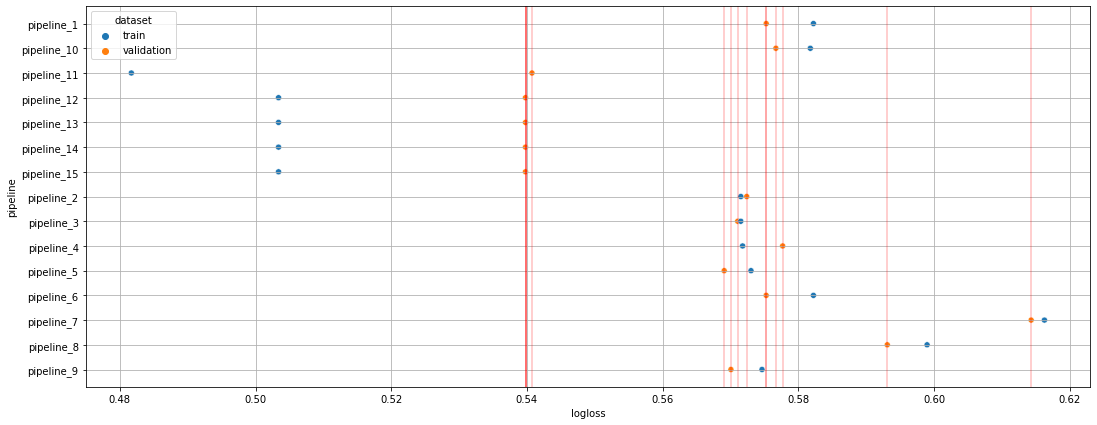

In [28]:
results_df_6_wave = pd.concat([results_df_5_wave,
                               results_df_6_wave]).sort_values('pipeline')
plot_pipelines_results(results_df_6_wave)

pipeline_12 is for now the winner...but maybe is quite overfitted...

In [29]:
experiments_runner(
    pipelines_to_run=[pipeline_12],
    split_instance=SplitDefault(),
    dataset=dataset,
    save_test_preds=True,
    skip_train_valid=True
)

Test estimations saved. Path: test_submission_pipeline_12.csv


,pipeline,dataset,logloss


In [30]:
def pipeline_16():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('scaler_', StandardScaler()),
        ('model_', MLPClassifier(random_state=77))
    ])

In [31]:
results_df_7_wave = experiments_runner(
    pipelines_to_run=[pipeline_16],
    split_instance=SplitDefault(),
    dataset=dataset
)

Running pipeline_16.
pipeline_16 run.


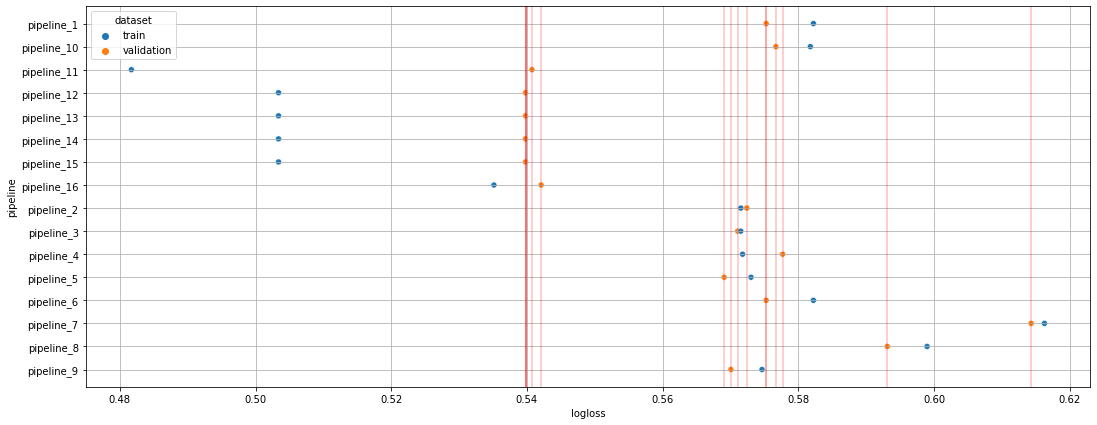

In [32]:
results_df_7_wave = pd.concat([results_df_6_wave,
                               results_df_7_wave]).sort_values('pipeline')
plot_pipelines_results(results_df_7_wave)

In [33]:
def pipeline_17():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('scaler_', StandardScaler()),
        ('model_', MLPClassifier(random_state=77, solver='lbfgs'))
    ])

In [34]:
results_df_8_wave = experiments_runner(
    pipelines_to_run=[pipeline_17],
    split_instance=SplitDefault(),
    dataset=dataset,
)

Running pipeline_17.
pipeline_17 run.


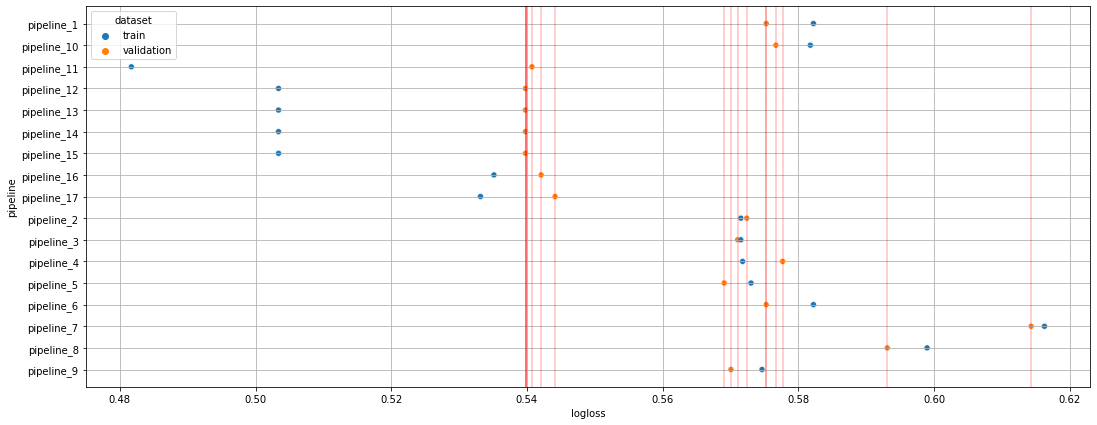

In [35]:
results_df_8_wave = pd.concat([results_df_7_wave,
                               results_df_8_wave]).sort_values('pipeline')
plot_pipelines_results(results_df_8_wave)

In [36]:
def pipeline_18():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('scaler_', StandardScaler()),
        ('model_', MLPClassifier(random_state=77, alpha=0.1))
    ])

def pipeline_19():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('scaler_', StandardScaler()),
        ('model_', MLPClassifier(random_state=77, alpha=0.01))
    ])

def pipeline_20():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('scaler_', StandardScaler()),
        ('model_', MLPClassifier(random_state=77, alpha=0.001))
    ])

In [37]:
results_df_9_wave = experiments_runner(
    pipelines_to_run=[pipeline_18, pipeline_19, pipeline_20],
    split_instance=SplitDefault(),
    dataset=dataset,
)

Running pipeline_18.
pipeline_18 run.
Running pipeline_19.
pipeline_19 run.
Running pipeline_20.
pipeline_20 run.


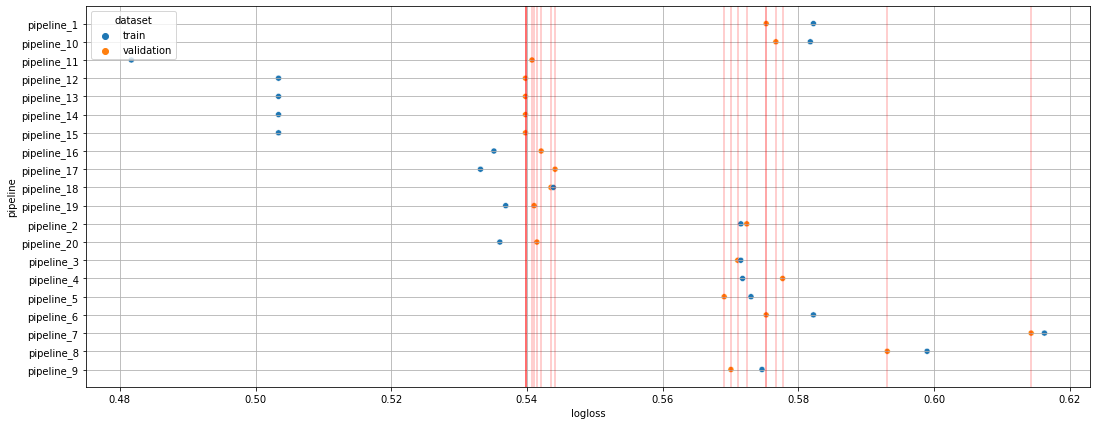

In [38]:
results_df_9_wave = pd.concat([results_df_8_wave,
                               results_df_9_wave]).sort_values('pipeline')
plot_pipelines_results(results_df_9_wave)

In [39]:
def pipeline_21():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('scaler_', StandardScaler()),
        ('model_', MLPClassifier(random_state=77, alpha=0.01, max_iter=50))
    ])

def pipeline_22():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('scaler_', StandardScaler()),
        ('model_', MLPClassifier(random_state=77, alpha=0.01, max_iter=100))
    ])

def pipeline_23():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('scaler_', StandardScaler()),
        ('model_', MLPClassifier(random_state=77, alpha=0.01, max_iter=150))
    ])

def pipeline_24():
    return Pipeline([
        ('imputer_', SimpleImputer()),
        ('scaler_', StandardScaler()),
        ('model_', MLPClassifier(random_state=77, alpha=0.01, max_iter=225))
    ])

In [40]:
results_df_10_wave = experiments_runner(
    pipelines_to_run=[pipeline_21, pipeline_22,
                      pipeline_23, pipeline_24],
    split_instance=SplitDefault(),
    dataset=dataset,
)

Running pipeline_21.
pipeline_21 run.
Running pipeline_22.
pipeline_22 run.
Running pipeline_23.
pipeline_23 run.
Running pipeline_24.
pipeline_24 run.


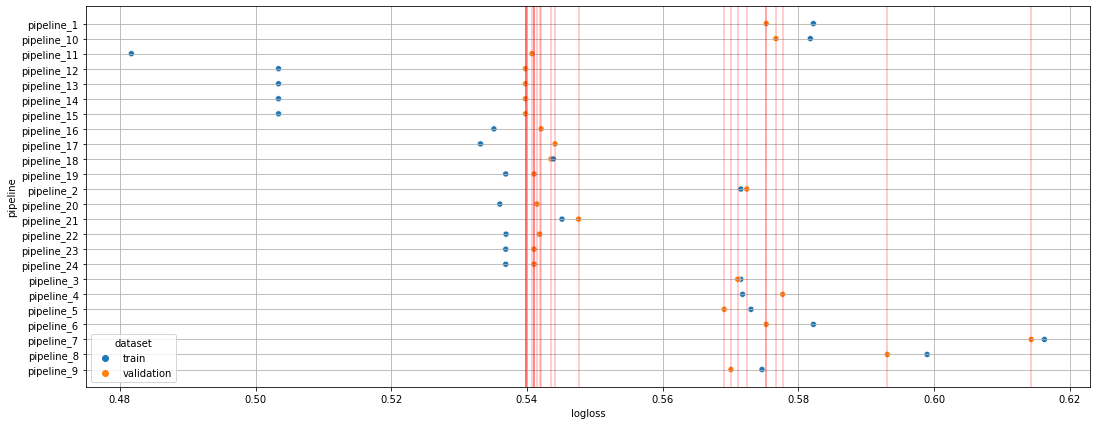

In [41]:
results_df_10_wave = pd.concat([results_df_9_wave,
                               results_df_10_wave]).sort_values('pipeline')
plot_pipelines_results(results_df_10_wave)

In [42]:
def pipeline_25():
    return Pipeline([
        ('imputer_', SimpleImputer(strategy='most_frequent')),
        ('scaler_', StandardScaler()),
        ('model_', MLPClassifier(random_state=77, alpha=0.01, max_iter=200))
    ])

In [43]:
results_df_11_wave = experiments_runner(
    pipelines_to_run=[pipeline_25],
    split_instance=SplitDefault(),
    dataset=dataset,
)

Running pipeline_25.
pipeline_25 run.


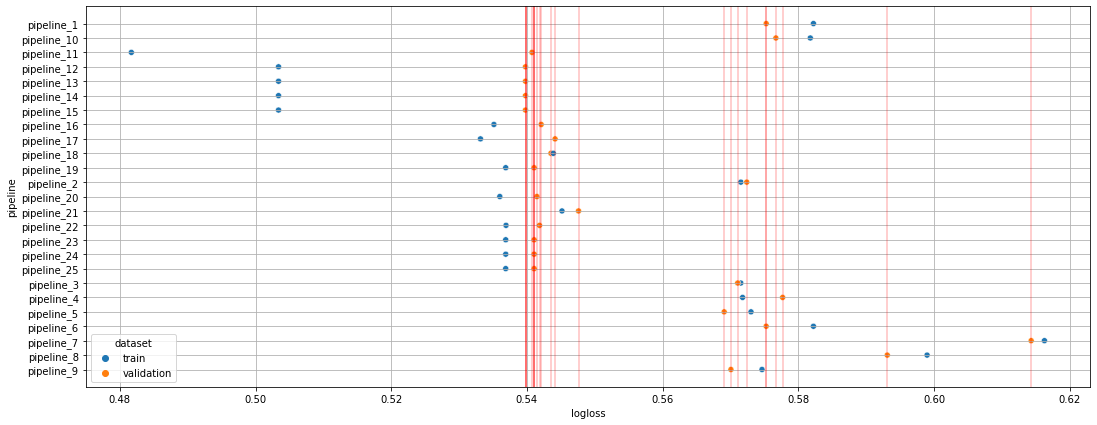

In [44]:
results_df_11_wave = pd.concat([results_df_10_wave,
                               results_df_11_wave]).sort_values('pipeline')
plot_pipelines_results(results_df_11_wave)

In [45]:
experiments_runner(
    pipelines_to_run=[pipeline_25],
    split_instance=SplitDefault(),
    dataset=dataset,
    save_test_preds=True,
    skip_train_valid=True
)

Test estimations saved. Path: test_submission_pipeline_25.csv


,pipeline,dataset,logloss


### Conclusion:

- pipeline_12 was the best result in this 24 hours-competition.